# Position Switch (PS) Data Reduction

## P. Schloerb
## October 2019

In a *position switch (PS)* observation, the telescope alternately observes two positions on the sky: (1) the *MAIN* position corresponding to the source we are trying to observe; and (2) the *REF* position which is located somewhere off of the source on blank sky.

A position switch spectrum makes several observations on MAIN and on REF and then computes a final reduced spectrum according to:

$$S \ = \ {{MAIN-REF}\over REF}$$

Once the above reduced spectrum is calculated, it may be calibrated by either multiplying $S$ by a constant value of system temperature or by multiplying by a spectrum of the system temperatures measured in each channel of the spectrometer:

$$S_{calibrated} \ = \ S \times T_{sys}$$

### Do the Necessary Imports 

In [3]:
# Python Imports
import numpy as np
import matplotlib.pyplot as pl

# Line Data Reduction Imports
from lmtslr.spec.spec import *
from lmtslr.utils.roach_file_utils import *
from lmtslr.ifproc.ifproc import *
from lmtslr.utils.ifproc_file_utils import *
from lmtslr.viewer.spec_viewer import *

from lmtslr.reduction.line_reduction import *



### Setup Reduction Parameters

This is a reduction of ObsNum 82480, which is an observation of the HCN 3-2 line in Comet 46P/Wirtanen, obtained in December 2018 with the 1mm EHT receiver.

In [4]:
# set all parameters to control the reduction and plot                                                         
data_path = '/Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/'
obsnum = 82480

pixel_number = 0
# this is the 1mm receiver - pixels 0 and 2 the two polarizations of bank 0
list_of_pixels = [0,2]
bank = 0

# calibration options
use_calibration = True
tsys = 180.

# baseline options
baseline_order = 0
plot_limits = [-20,20,-1,1]
baseline_regions = [[-20,-10],[10,20]]
line_integral_regions = [[-2,2]]




## Reduce the Position Switching Spectrum

The method `read_obsnum_ps` carries out the complete PS reduction on a single ObsNum using the following arguments:

* `obsnum` - the ObsNum of the observation to be reduced
* `list_of_pixels` - a python list of the backend pixels to be reduced. For SEQUOIA observations, these correspond to the pixel ids.  For the 1mm receiver, only "pixels" 0-3 are possible. THe two polarizations of bank 0 are in channels 0 and 2.  The two polarizations of bank 1 are in channels 1 and 3. 
* `bank` - identifies the bank to be processed.
* `use_calibration` - a boolean to indicate whether to use calibration spectrum to calibrate or a simple multiple.
* `tsys` - the system temperature to be used if `use_calibration` is False [default = 150.].
* `data_path` - the path to the top level of the data directories [default = '/data_lmt/']

The method returns two objects: (1) an `ifproc_data` object containing header information read from the ifproc file; and (2) a `spec_bank_data` object which will contain spectral line data for all desired "pixels" as well as important spectral line header information.


At this time, there are two additional parameters which *should* be included with as arguments to `reduce_obsnum_ps` but have not been:

* `type` can be set to 1 or 2, with type=2 as the default.

    * type=1: In a type 1 reduction, all MAIN observations and REF observations are averaged to give a single MAIN and REF spectrum.  The reduced spectrum saved as a variable in the roach class called `ps_spectrum`.
    * type=2: In a type 2 reduction, contiguous MAIN and REF observations are grouped together to form a set of MAIN's and REF's.  Then pairs of MAIN and REF spectra are used to form a set of PS spectra.  The final result is the average of these PS spectra.

* `normal_ps` is either True or False, with True as the default.  In a normal PS, the REF position is off source and therefore it is appropriate to use it in the denominator of our reduced PS spectrum:  

$$ S \ = \ {{MAIN-REF}\over REF}$$

However, there are some cases (Beam Switching) where a spectrum that is formed this way would have the line in the denominator.  In this case one can choose `normal_ps=False` so that the reduced spectrum is 

$$ S \ = \ {{REF-MAIN}\over MAIN}$$

In [5]:
# create ifproc and spec objects for this obsnum; reduce with ps algorithm                                
I,S = read_obsnum_ps(obsnum, list_of_pixels, bank, use_calibration, tsys=tsys, path=data_path)



found roach0_82480_0_1_46P_2018-12-21_074022.nc
append roach0_82480_0_1_46P_2018-12-21_074022.nc
found ifproc_2018-12-21_082480_00_0001.nc
before read npix
from pixels npix = 1
from xlen npix = 4
TRACKING Msip1mm PIXEL  0
/Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/ifproc/ifproc_2018-12-21_082480_00_0001.nc does not have map parameters
/Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/ifproc/ifproc_2018-12-21_082480_00_0001.nc does not have bs parameters
82480 is a Ps observation
/Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/ifproc/ifproc_2018-12-21_082480_00_0001.nc does not have Ps parameters Header.Ps.Mode
read_roach /Users/schloerb/Desktop/LMT/DataReduction/NewDataReduction/pipeline/example_data/spectrometer/roach0/roach0_82480_0_1_46P_2018-12-21_074022.nc
r:0 inp:0 pix:0 to:-0.030000
r:0 inp:2 pix:2 to:-0.030000
found roach0_82479_0_1_46P_2018-12-21_073958.nc
append roach0_82479_

/Users/schloerb/anaconda/envs/lmtslr/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/schloerb/Desktop/LMT/SPECTRALLINE/lmtslr/spec/spec.py:142: RuntimeWarning: invalid value encountered in true_divide
  ps_list[i,:] = (self.main_spectra[i,:]-self.reference_spectra[i,:])/self.reference_spectra[i,:]
/Users/schloerb/Desktop/LMT/SPECTRALLINE/lmtslr/spec/spec.py:142: RuntimeWarning: divide by zero encountered in true_divide
  ps_list[i,:] = (self.main_spectra[i,:]-self.reference_spectra[i,:])/self.reference_spectra[i,:]


### Line Reduction

There are two important classes for dealing with spectral line data reduction:

The `LineData` class handles detailed header information and the actual data from a spectrum.  It provides the methods necessary to, for example, convert the x-axis two different frames of reference, resample the spectrum or slice the spectrum to limit the number of channels for processing.  `LineData` is derived from the `LineDataHeader` class, which only deals with header variables and provides the methods for velocity and frequency calculations.

The `Line` class provides methods to deal with common spectral line opertions, such as removing baselines and smoothing.  Some of the `LineData` methods return a `Line` object as a result.


### Create LineData Objects

The first step will be to create a `LineData` object for each polarization of the line.

Text(0.5, 0, 'VSRCE')

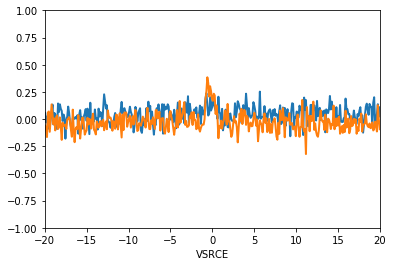

In [6]:
# create a LineData object for each polarization
LD_0 = LineData(I,bank,S.nchan,S.bandwidth,S.roach[0].ps_spectrum)
LD_1 = LineData(I,bank,S.nchan,S.bandwidth,S.roach[1].ps_spectrum)

# select "V Source" option since this is a comet spectrum
LD_0.x_vsrc()
LD_1.x_vsrc()

# make a plot of the two spectra
pl.plot(LD_0.xarray,LD_0.yarray)
pl.plot(LD_1.xarray,LD_1.yarray)
pl.axis(plot_limits)
pl.xlabel(LD_0.xname)






### Create Line Objects

Now we will create `Line` objects for each spectrum so that we can fit a baseline.

Although the spectra are aligned for this simple case, we'll illustrate the use of resampling with the methods `xgen` .

Baselines are removed from the `Line` objects using the python list of lists to provide the regions for the fit.  The method `xlist` finds the list of channels corrresponding to the baseline regions.  The `baseline` method then does the fit and removes the result.  The fit polynomial is stored in `Line.baseline` and the rms to the fit is stored in `Line.rms`.


Baseline RMS = 0.074382
Baseline RMS = 0.070793


Text(0.5, 0, 'VSRCE')

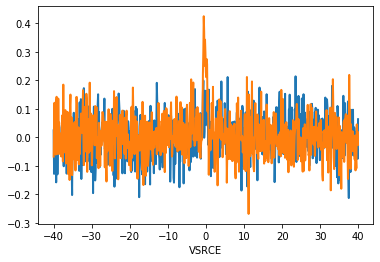

In [7]:
# create a Line object with samples from -40 to +40 in velocity steps corresponding to the channel spacing
L_0 = LD_0.xgen(-40., 40., LD_0.dxdc)
L_1 = LD_1.xgen(-40., 40., LD_0.dxdc)

# for the first line, find baseline channels and fit baseline
blist,nb = L_0.xlist(baseline_regions)
L_0.baseline(blist,nb,baseline_order)
print('Baseline RMS = %f'%(L_0.rms))

blist,nb = L_0.xlist(baseline_regions)
L_1.baseline(blist,nb,baseline_order)
print('Baseline RMS = %f'%(L_1.rms))

pl.plot(L_0.xarray,L_0.yarray)
pl.plot(L_1.xarray,L_1.yarray)
pl.xlabel(L_0.xname)


### Line Averaging

Now average the two polarizations together.  Note that spectra to be averaged are assumed to be aligned in frequency or velocity space.

The `Accum` class accumulates the data from many spectra.  We add data using the `Accum.load` method.  This method takes, as arguments, the `yarray` of the data and the `weight` to be applied for the spectrum in an average.  In the example below, we weight by inverse of rms-squared.

The `Accum.ave` method computes the average spectrum.

Average RMS = 0.047403


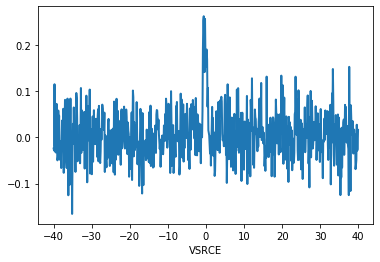

In [8]:
A = Accum()
A.load(L_0.yarray, 1.0/L_0.rms**2)
A.load(L_1.yarray, 1.0/L_1.rms**2)

A.ave()

# put the average into a new line object and fit baseline
L_Average = Line(L_0.iarray,L_0.xarray,A.average,L_0.xname)
blist, nb = L_Average.xlist(baseline_regions)
L_Average.baseline(blist,nb,baseline_order)
print('Average RMS = %f'%(L_Average.rms))

# plot the average
pl.figure()
pl.plot(L_Average.xarray,L_Average.yarray)
#pl.axis(plot_limits)
pl.xlabel(L_Average.xname);